# 20260115: 實作NCSN+Annealing Langevin Sampling - 1D

1. 建構 NCSN (Model)：寫一個神經網路，輸入是 $(x, \sigma)$，輸出是 $\epsilon$ (或 Score)。 定義 Loss Function 來訓練它。
2. 實作 Algorithm 1 (Sampling)：寫一個函式，裡面有兩層迴圈。外層控制 $\sigma$ (Annealing)。內層跑 $T$ 次演算法中第 6 行的公式 (Langevin Step)。



## Model
根據 NCSN 的目標函數定義，原始的 Denoising Score Matching 損失函數為：$$\ell(\theta; \sigma) \triangleq \frac{1}{2} \mathbb{E}_{p_{\text{data}}(x)} \mathbb{E}_{\tilde{x} \sim \mathcal{N}(x, \sigma^2 I)} \left[ \left\| s_\theta(\tilde{x}, \sigma) + \frac{\tilde{x} - x}{\sigma^2} \right\|_2^2 \right]$$

其中總損失函數定義為 $$\mathcal{L} = \frac{1}{L} \sum_{i=1}^L \lambda(\sigma_i) \ell(\theta; \sigma_i).$$

為了數值穩定性，NCSN 選擇權重函數 $\lambda(\sigma_i) = \sigma_i^2$。

實作方面，我們定義一個噪聲預測網路 $\boldsymbol{\epsilon}_\theta(\tilde{x}, \sigma)$，並令：$$s_\theta(\tilde{x}, \sigma) \triangleq -\frac{\boldsymbol{\epsilon}_\theta(\tilde{x}, \sigma)}{\sigma}$$

## Langevin
在演算法中(第6行):
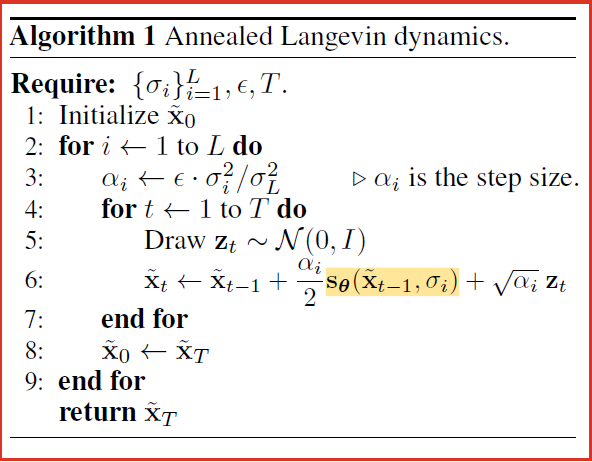
* 原版 (預測 Score):$$\tilde{x}_t \leftarrow \tilde{x}_{t-1} + \frac{\alpha_i}{2} \mathbf{s_\theta}(\tilde{x}_{t-1}, \sigma_i) + \sqrt{\alpha_i} z_t$$
* 新版 (預測 $\epsilon$):因為 $\text{Score} \approx -\frac{\epsilon}{\sigma}$，所以把 $s_\theta$ 換掉：$$\tilde{x}_t \leftarrow \tilde{x}_{t-1} + \frac{\alpha_i}{2} \left( -\frac{\boldsymbol{\epsilon}_\theta(\tilde{x}_{t-1}, \sigma_i)}{\sigma_i} \right) + \sqrt{\alpha_i} z_t$$

---

# Model

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

def get_data(n_samples):
    # 20% 在(-5)，80% 在(5)
    weights = torch.Tensor([0.2, 0.8])
    means = torch.Tensor([-5, 5])
    
    # 採樣
    indices = torch.multinomial(weights, n_samples, replacement=True)
    samples = torch.normal(means[indices], 1.0) # std=1.0
    return samples.unsqueeze(1) # shape: [N, 1]

In [ ]:
class NCSN_1D(nn.Module):
    def __init__(self, n_sigma): # 引入10個 noise levels
        super().__init__()
        self.sigma_embed = nn.Embedding(n_sigma, 32)
        
        self.net = nn.Sequential(
            nn.Linear(1 + 32, 64), 
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)       # 輸出預測的 noise (epsilon)
        )
        
    def forward(self, x, sigma_idx):
        # x: [batch, 1]
        # sigma_idx: [batch] (整數 0 ~ L-1)
        
        embed = self.sigma_embed(sigma_idx)
        input_feat = torch.cat([x, embed], dim=1) # 把 x 跟 sigma 資訊接起來
        
        out = self.net(input_feat)
        return out # 預測 epsilon

In [ ]:
# Hyperparameters
sigma_list = torch.tensor(np.geomspace(50, 0.01, 10)).float() # Geometric sequence
model = NCSN_1D(n_sigma=10)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,       
    patience=200,     
    verbose=True
)
loss_history = []
n_samples=10000
num_steps=5000
data = get_data(n_samples)

# Training
for epoch in range(1, num_steps+1):
    sigma_idx = torch.randint(0, 10, (data.shape[0],))
    sigmas = sigma_list[sigma_idx].view(-1, 1)
    
    z = torch.randn_like(data)                    #<<<<<<< random noise
    perturbed_data = data + sigmas * z
    
    pred_noise = model(perturbed_data, sigma_idx) #<<<<<<< model    
    loss = ((pred_noise - z) ** 2).mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    scheduler.step(loss)
    loss_history.append(loss.item())
    
    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | Loss: {loss.item():6f}")

c:\Users\user\.conda\envs\ml_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch  200 | Loss: 0.613320
Epoch  400 | Loss: 0.602283
Epoch  600 | Loss: 0.611560
Epoch  800 | Loss: 0.596191
Epoch 1000 | Loss: 0.599481
Epoch 1200 | Loss: 0.609299
Epoch 1400 | Loss: 0.587532
Epoch 1600 | Loss: 0.581110
Epoch 1800 | Loss: 0.575063
Epoch 2000 | Loss: 0.582504
Epoch 2200 | Loss: 0.601697
Epoch 2400 | Loss: 0.592538
Epoch 2600 | Loss: 0.596765
Epoch 2800 | Loss: 0.601093
Epoch 3000 | Loss: 0.568900
Epoch 3200 | Loss: 0.601215
Epoch 3400 | Loss: 0.608541
Epoch 3600 | Loss: 0.592500
Epoch 3800 | Loss: 0.594704
Epoch 4000 | Loss: 0.567239
Epoch 4200 | Loss: 0.592388
Epoch 4400 | Loss: 0.582961
Epoch 4600 | Loss: 0.576955
Epoch 4800 | Loss: 0.590595
Epoch 5000 | Loss: 0.573668


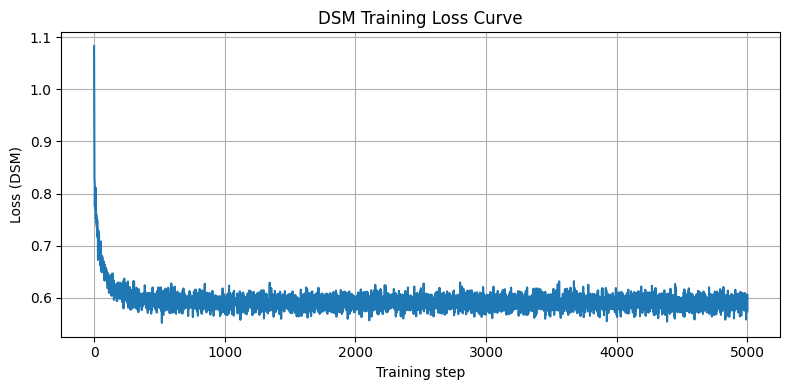

In [5]:
import matplotlib.pyplot as plt

def plot_loss_curve(loss_list):
    """
    loss_list: Python list or Tensor containing loss values for each step
    """
    plt.figure(figsize=(8,4))
    plt.plot(loss_list, linewidth=1.5)
    plt.xlabel("Training step")
    plt.ylabel("Loss (DSM)")
    plt.title("DSM Training Loss Curve")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_loss_curve(loss_history)

# Annealed Langevin

In [ ]:
@torch.no_grad()
def annealed_langevin(model, sigma_list, n_steps, step_lr, deterministic):
    x = torch.rand(1000, 1) * 20 - 10   ## 撒1000粒點在[-10, 10]之間
    
    # 2. Annealing Loop 
    for i, sigma in enumerate(sigma_list):
        alpha = step_lr * (sigma / sigma_list[-1])**2 
        # Step size schedule #epsilon -> learning rate

        # 3. Langevin Loop 
        for t in range(n_steps):
            z_t = torch.randn_like(x)
            
            sigma_idx = torch.ones(x.shape[0], dtype=torch.long) * i
            pred_noise = model(x, sigma_idx)
            score = -pred_noise / sigma
            
            # Langevin Update
            noise_term = torch.sqrt(alpha) * z_t
            grad_term = 0.5 * alpha * score
            
            if deterministic:
                # True: No Noise
                x = x + grad_term 
            else:
                # False: With Noise
                x = x + grad_term + noise_term 

    return x

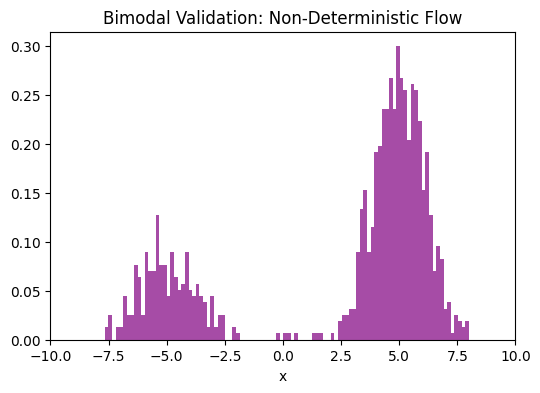

In [7]:
# === 測試雙峰 (Bimodal) ===
final_samples = annealed_langevin(
    model, sigma_list, n_steps=100, step_lr=2e-5, deterministic=False)

# 畫圖檢查
plt.figure(figsize=(6, 4))
plt.hist(final_samples, bins=100, density=True, color='purple', alpha=0.7)
plt.title("Bimodal Validation: Non-Deterministic Flow")
plt.xlim(-10, 10) # 設定範圍看清楚兩邊
plt.xlabel("x")
plt.show()

In [8]:
import numpy as np

@torch.no_grad()
def annealed_langevin_trajectory(model, sigma_list, n_steps, step_lr, deterministic):
    # 1. 初始化
    x = torch.rand(1000, 1) * 20 - 10 
    
    # 用來存軌跡的 list，先存初始狀態
    # shape: [Steps, Batch, 1]
    trajectory = [x.cpu().clone().numpy()] 
    
    # 2. Annealing Loop
    for i, sigma in enumerate(sigma_list):
        alpha = step_lr * (sigma / sigma_list[-1])**2
        
        for t in range(n_steps):
            z_t = torch.randn_like(x)
            
            sigma_idx = torch.ones(x.shape[0], dtype=torch.long) * i
            pred_noise = model(x, sigma_idx)
            score = -pred_noise / sigma
            
            noise_term = torch.sqrt(alpha) * z_t
            grad_term = 0.5 * alpha * score
            
            if deterministic:
                x = x + grad_term # 無噪聲: 軌跡會很滑順
            else:
                x = x + grad_term + noise_term # 有噪聲: 軌跡會抖動
            
            # 每一都存下來 (或是每 10 步存一次省記憶體)
            trajectory.append(x.cpu().clone().numpy())
            
    return np.array(trajectory) # 轉成 numpy array 方便畫圖

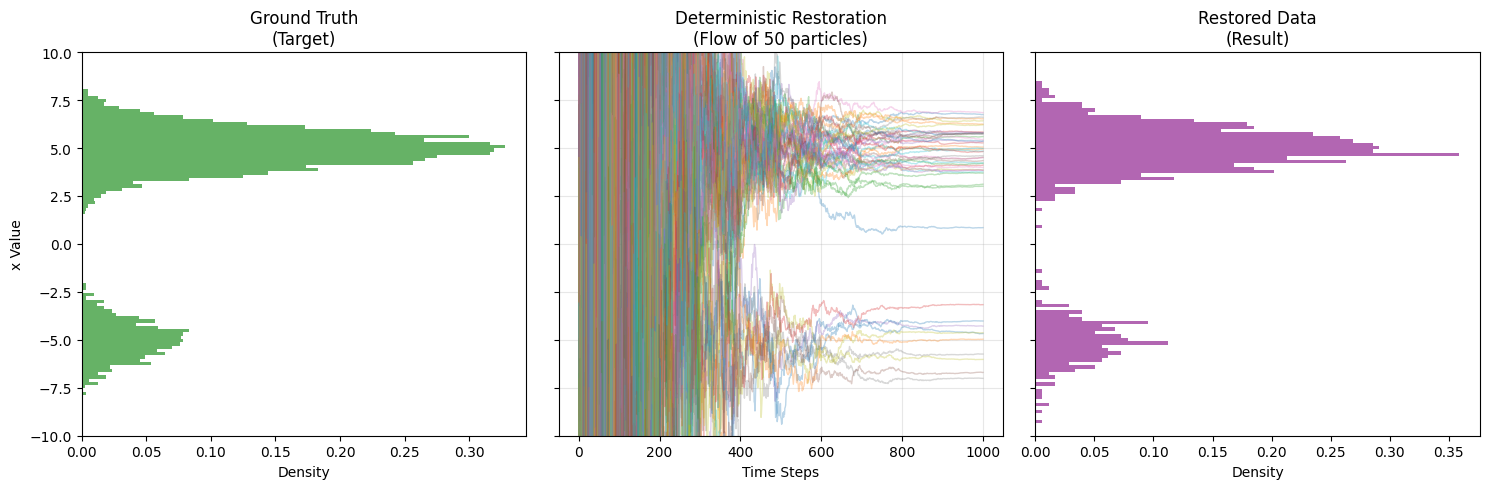

In [11]:
import matplotlib.pyplot as plt

# 1. 跑一次 Deterministic 採樣拿到軌跡
history = annealed_langevin_trajectory(
    model, sigma_list, n_steps=100, step_lr=2e-5, deterministic=False
)

gt_data = get_data(n_samples=5000).numpy()

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# --- 左圖: Ground Truth (Target) ---
axes[0].hist(gt_data, bins=100, density=True, orientation='horizontal', color='green', alpha=0.6)
axes[0].set_title("Ground Truth\n(Target)")
axes[0].set_ylim(-10, 10) 
axes[0].set_ylabel("x Value")
axes[0].set_xlabel("Density")

# --- 中圖: Deterministic Restoration (Trajectory) ---
num_lines_to_plot = 50 
steps = np.arange(history.shape[0])

# history[:, i, 0] 代表第 i 個粒子的所有時間點位置
for i in range(num_lines_to_plot):
    axes[1].plot(steps, history[:, i, 0], alpha=0.3, linewidth=1)

axes[1].set_title(f"Deterministic Restoration\n(Flow of {num_lines_to_plot} particles)")
axes[1].set_xlabel("Time Steps")
axes[1].grid(True, alpha=0.3)

# --- 右圖: Restored Data (Result) ---
final_data = history[-1, :, 0]
axes[2].hist(final_data, bins=100, density=True, orientation='horizontal', color='purple', alpha=0.6)
axes[2].set_title("Restored Data\n(Result)")
axes[2].set_xlabel("Density")

plt.tight_layout()
plt.show()